### Summaries

1. We compared performance of epsilon-based and softmax-based bandit algorithms for the best values of epsilon and tau tuned during the first class, and for the decreasing epsilon.

2.  **Model_1(Epsilon=0.2)**,

    **Model_2(Epsilon=1/(1+episode_number)^0.5)**, 
    
    **Model_Softmax(Tau=1.0)**

3. We trained on 8 Bandit environments described lower:
 - 1) 'BanditTenArmedGaussian',
 - 2) 'BanditTenArmedRandomFixed',
 - 3) 'BanditTenArmedRandomRandom',
 - 4) 'BanditTenArmedUniformDistributedReward',
 - 5) 'BanditTwoArmedDeterministicFixed',
 - 6) 'BanditTwoArmedHighHighFixed',
 - 7) 'BanditTwoArmedHighLowFixed',
 - 8) 'BanditTwoArmedLowLowFixed'
 
4. Average running time for Softmax-Choice model per episode is about 0.043 sec, while for Epsilon-Choice model it is about 0.013 which is 3 times faster on all the Bandit environments!

5. Epsilon-Choice models provide better average rewards on all the Bandit environments!    
      SO, Epsilon-Choice models Model_1 and Model_2 are faster, and perform better than Softmax-Choice model.

6. Model_2 with decreasing Epsilon performs better than Model_1 on the next environments:
  - 1) 'BanditTenArmedGaussian'
  - 3) 'BanditTenArmedRandomRandom'
  - 5) 'BanditTwoArmedDeterministicFixed'
  - 7) 'BanditTwoArmedHighLowFixed'
 
 While on the other environments results are comparable.
     
7. Epsilon-based model with decreasing epsilon is the most preferable. 

**Environments**:

 1) **BanditTenArmedGaussian**: 
 10 armed bandit mentioned on page 30 of Reinforcement Learning: An Introduction (Sutton and Barto)
 
 2) **BanditTenArmedRandomFixed**: 
 10 armed bandit with random probabilities assigned to payouts
 
 3) **BanditTenArmedRandomRandom**: 
 10 armed bandit with random probabilities assigned to both payouts and rewards
 
 4) **BanditTenArmedUniformDistributedReward**: 
 10 armed bandit with that always pays out with a reward s lected from a uniform distribution
 
 5) **BanditTwoArmedDeterministicFixed**: 
 Simplest case where one bandit always pays, and the other always doesn't
 
 6) **BanditTwoArmedHighHighFixed**: 
 Stochastic version with a small difference between which bandit pays where both are good
 
 7) **BanditTwoArmedHighLowFixed**: 
 Stochastic version with a large difference between which bandit pays out of two choices
 
 8) **BanditTwoArmedLowLowFixed**: 
 Stochastic version with a small difference between which bandit pays where both are bad

In [166]:
import gym_bandits
import gym
import time

import numpy as np
import seaborn as sns

%matplotlib inline
#plt.figure(figsize=(3,4))
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [172]:
def prepare_env(func):
    def wrapped_func(*args,**kwargs):
        API_KEY = 'sk_YME8FzLCT4ZXZrXuANMg'
        env, chosen_arms, rewards, best_action_chosen, ave_time_per_episode = func(*args,**kwargs)
        env.close()
        return chosen_arms, rewards, best_action_chosen, ave_time_per_episode
    return wrapped_func

In [235]:
class Bandit(object):
    def __init__(self, epsilon, actions, N, Q, t):
        self.epsilon = epsilon
        self.actions = actions
        self.N = N
        self.Q = Q
        self.t = t
    
    def softmax(self, values):
        e = np.exp(np.array(values) / self.t)
        dist = e / np.sum(e)
        return dist
    
    def weighted_choice(self):
        totals = np.cumsum(self.softmax(self.Q))
        norm = totals[-1]
        throw = np.random.rand()*norm
        chosen_action = np.searchsorted(totals, throw)
        return (chosen_action, 1) if chosen_action == np.argmax(self.Q) else (chosen_action, 0)
    
    def choice_action(self, if_weighted=False):
        if if_weighted:
            return self.weighted_choice()
        if np.random.random()>self.epsilon:
            return np.argmax(self.Q), 1
        else:
            return np.random.randint(0, len(self.actions)), 0

    def update(self, action, reward):
        action_ix = self.actions.index(action)
        self.Q[action_ix] = 1.0*(self.Q[action_ix]*self.N[action_ix]+reward)/(self.N[action_ix]+1)
        self.N[action_ix] += 1
    
    def reset(self):
        self.Q = np.zeros(len(self.actions))
        self.N = np.zeros(len(self.actions))
    
    def update_epsilon(self, episode_number):
        self.epsilon = 1/(1+episode_number)**0.99

In [203]:
@prepare_env
def train_bandit(env, bandit, n_episodes, n_steps, if_weighted=False, change_epsilon=False):    
    start_time = time.time()
    number_arms = env.action_space.n
    arms = range(number_arms)    
    chosen_arms = np.zeros((n_episodes, n_steps))
    rewards = np.zeros((n_episodes, n_steps))
    best_action_chosen = np.zeros((n_episodes, n_steps))
    for episode in range(n_episodes):
        if change_epsilon:
            bandit.update_epsilon(episode)
        ep_reward = 0
        bandit.reset()
        for step in range(n_steps):
            chosen_arm_ix, best_action = bandit.choice_action(if_weighted)
            chosen_arms[episode,step] = chosen_arm_ix
            best_action_chosen[episode,step] = best_action
            new_s, reward, done, _ = env.step(chosen_arm_ix)
            ep_reward += reward
            rewards[episode,step] = reward
            bandit.update(chosen_arm_ix, reward)
    ave_time_per_episode = 1.0*(time.time()-start_time)/n_episodes
    return env, chosen_arms, rewards, best_action_chosen, ave_time_per_episode

In [175]:
def prepare_env_names(envs, postfix):
    return [str(env).split()[0].strip('<')+postfix for env in envs]

In [177]:
ENVS = (gym_bandits.BanditTenArmedGaussian(), 
        gym_bandits.BanditTenArmedRandomFixed(),
        gym_bandits.BanditTenArmedRandomRandom(),
        gym_bandits.BanditTenArmedUniformDistributedReward(),
        gym_bandits.BanditTwoArmedDeterministicFixed(),
        gym_bandits.BanditTwoArmedHighHighFixed(),
        gym_bandits.BanditTwoArmedHighLowFixed(),
        gym_bandits.BanditTwoArmedLowLowFixed())

chosen_arms_list_w, rewards_list_w, best_action_chosen_list_w = [], [], []
for env in ENVS:
    n = env.action_space.n
    bandit = Bandit(0.2, list(range(n)), np.zeros(n), np.zeros(n), 1.0)
    chosen_arms, rewards, best_action_chosen, ave_time_per_episode = train_bandit(
        env, bandit, 500, 1500, if_weighted=True)
    chosen_arms_list_w.append(chosen_arms)
    rewards_list_w.append(rewards)
    best_action_chosen_list_w.append(best_action_chosen)
    print("Finished softmax model: ", prepare_env_names([env],"")[0], 
          " AveReward %s" % str(rewards.sum()/(500*1500)),
          "  AveRunTime %s" % str(ave_time_per_episode))

chosen_arms_list, rewards_list, best_action_chosen_list = [], [], []
for env in ENVS:
    n = env.action_space.n
    bandit = Bandit(0.2, list(range(n)), np.zeros(n), np.zeros(n), 1.0)
    chosen_arms, rewards, best_action_chosen, ave_time_per_episode = train_bandit(env, bandit, 500, 1500)
    chosen_arms_list.append(chosen_arms)
    rewards_list.append(rewards)
    best_action_chosen_list.append(best_action_chosen)
    print("Finished epsilon greedy model: ", prepare_env_names([env],"")[0], 
          " Average reward %s" % str(rewards.sum()/(500*1500)),
          "  AveRunTime %s" % str(ave_time_per_episode))


Finished softmax model:  BanditTenArmedGaussian  AveReward 0.0185125592292   AveRunTime 0.05696750593185425
Finished softmax model:  BanditTenArmedRandomFixed  AveReward 0.646794666667   AveRunTime 0.04092580366134643
Finished softmax model:  BanditTenArmedRandomRandom  AveReward 0.28620648049   AveRunTime 0.040488510131835936
Finished softmax model:  BanditTenArmedUniformDistributedReward  AveReward 0.754145154632   AveRunTime 0.04619111633300781
Finished softmax model:  BanditTwoArmedDeterministicFixed  AveReward 0.731392   AveRunTime 0.044417518138885496
Finished softmax model:  BanditTwoArmedHighHighFixed  AveReward 0.852408   AveRunTime 0.04334917211532593
Finished softmax model:  BanditTwoArmedHighLowFixed  AveReward 0.587026666667   AveRunTime 0.04108208179473877
Finished softmax model:  BanditTwoArmedLowLowFixed  AveReward 0.151794666667   AveRunTime 0.04097331428527832
Finished epsilon greedy model:  BanditTenArmedGaussian  Average reward 0.528936086928   AveRunTime 0.02265883

In [178]:
def get_episode_rewards(rewards_list, epsilon_list, episode_number=0, average_between_episodes=False):
    fig, axs = plt.subplots(ncols=2)
    fig.set_figwidth(20)
    for i in range(len(rewards_list)):
        if average_between_episodes:
            episode_rewards = rewards_list[i].mean(axis=0)
        else:
            episode_rewards = rewards_list[i][episode_number,:]
        axs[0].plot(np.cumsum(episode_rewards), label=str(epsilon_list[i]))
        axs[1].plot(np.cumsum(episode_rewards)/(1+np.array(range(len(episode_rewards)))), label=str(epsilon_list[i]))
    title_postfix = 'Episode %s'%str(episode_number) if not average_between_episodes else 'Averaged between episodes' 
    axs[0].set_title('Cumulative rewards. ' + title_postfix)        
    axs[1].set_title('Average rewards. ' + title_postfix)
    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')

['BanditTenArmedGaussian', 'BanditTenArmedRandomFixed']


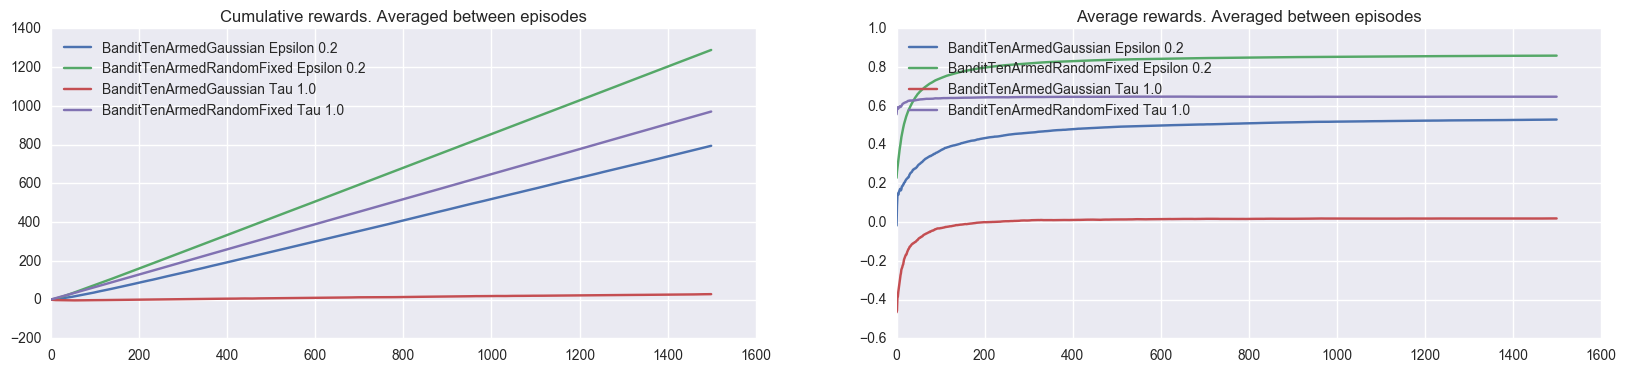

In [185]:
print(prepare_env_names(ENVS[:2],""))
get_episode_rewards(rewards_list[:2]+rewards_list_w[:2], 
                    prepare_env_names(ENVS[:2], " Epsilon 0.2") + prepare_env_names(ENVS[:2], " Tau 1.0"), 
                    average_between_episodes=True)

['BanditTenArmedRandomRandom', 'BanditTenArmedUniformDistributedReward']


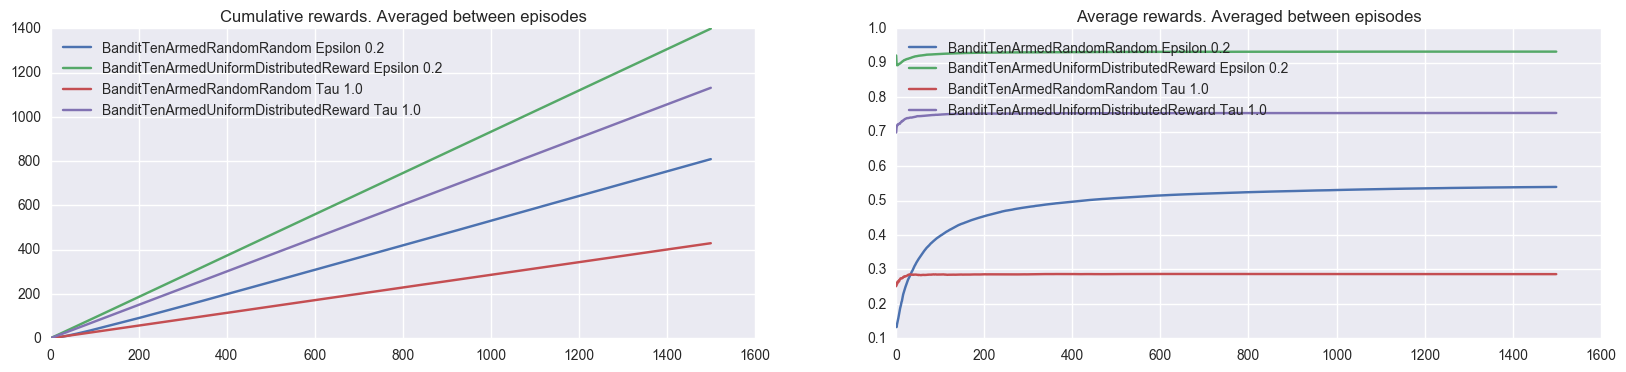

In [187]:
print(prepare_env_names(ENVS[2:4],""))
get_episode_rewards(rewards_list[2:4]+rewards_list_w[2:4], 
                    prepare_env_names(ENVS[2:4], " Epsilon 0.2") + prepare_env_names(ENVS[2:4], " Tau 1.0"), 
                    average_between_episodes=True)

['BanditTwoArmedDeterministicFixed', 'BanditTwoArmedHighHighFixed']


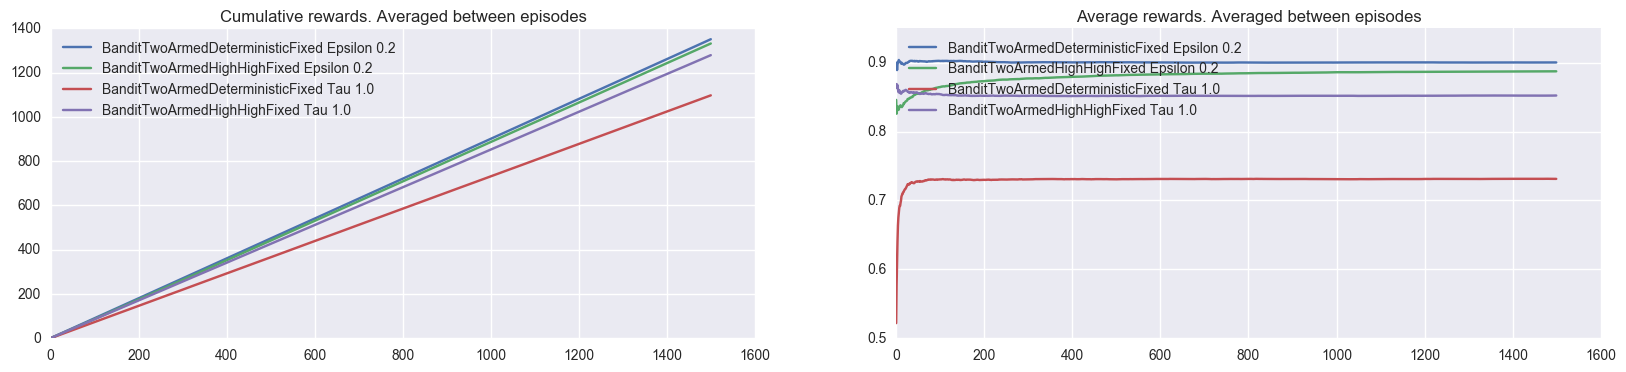

In [188]:
print(prepare_env_names(ENVS[4:6],""))
get_episode_rewards(rewards_list[4:6]+rewards_list_w[4:6], 
                    prepare_env_names(ENVS[4:6], " Epsilon 0.2") + prepare_env_names(ENVS[4:6], " Tau 1.0"), 
                    average_between_episodes=True)

['BanditTwoArmedHighLowFixed', 'BanditTwoArmedLowLowFixed']


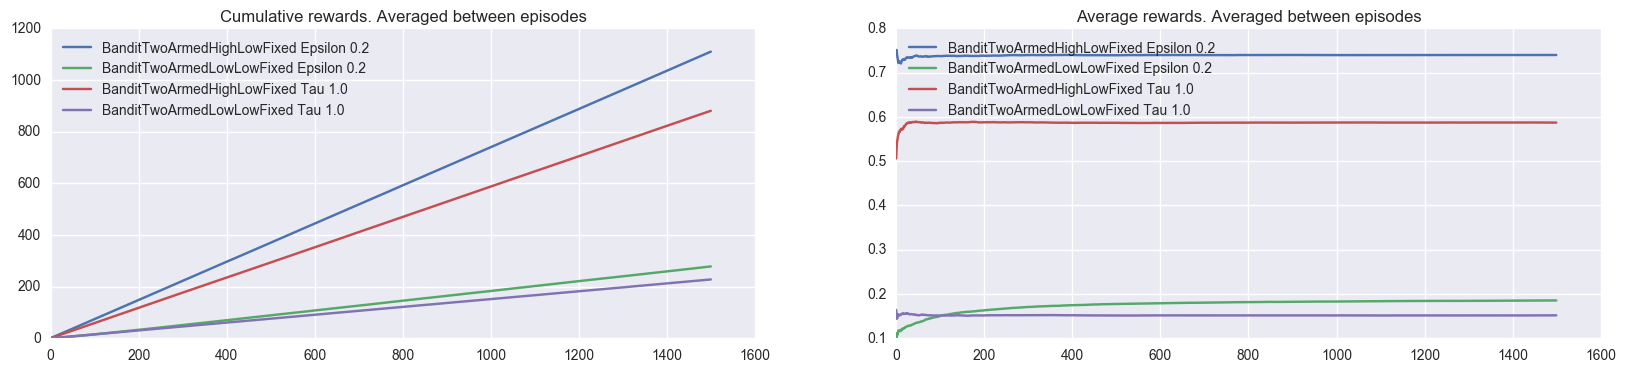

In [189]:
print(prepare_env_names(ENVS[6:8],""))
get_episode_rewards(rewards_list[6:8]+rewards_list_w[6:8], 
                    prepare_env_names(ENVS[6:8], " Epsilon 0.2") + prepare_env_names(ENVS[6:8], " Tau 1.0"), 
                    average_between_episodes=True)

### Decreasing epsilon over time

In [206]:
chosen_arms_list_c, rewards_list_c, best_action_chosen_list_c = [], [], []
for env in ENVS:
    n = env.action_space.n
    bandit = Bandit(0.2, list(range(n)), np.zeros(n), np.zeros(n), 1.0)
    chosen_arms, rewards, best_action_chosen, ave_time_per_episode = train_bandit(
        env, bandit, 500, 1500, change_epsilon=True)
    chosen_arms_list_c.append(chosen_arms)
    rewards_list_c.append(rewards)
    best_action_chosen_list_c.append(best_action_chosen)
    print("Finished epsilon greedy model: ", prepare_env_names([env],"")[0], 
          " Average reward %s" % str(rewards.sum()/(500*1500)),
          "  AveRunTime %s" % str(ave_time_per_episode))


Finished epsilon greedy model:  BanditTenArmedGaussian  Average reward 1.04790690497   AveRunTime 0.024200695991516114
Finished epsilon greedy model:  BanditTenArmedRandomFixed  Average reward 0.848413333333   AveRunTime 0.01585056781768799
Finished epsilon greedy model:  BanditTenArmedRandomRandom  Average reward 0.757678789448   AveRunTime 0.014610082149505614
Finished epsilon greedy model:  BanditTenArmedUniformDistributedReward  Average reward 0.914645505152   AveRunTime 0.01828337001800537
Finished epsilon greedy model:  BanditTwoArmedDeterministicFixed  Average reward 0.956822666667   AveRunTime 0.01379057216644287
Finished epsilon greedy model:  BanditTwoArmedHighHighFixed  Average reward 0.886153333333   AveRunTime 0.014022026062011719
Finished epsilon greedy model:  BanditTwoArmedHighLowFixed  Average reward 0.7737   AveRunTime 0.013449411869049072
Finished epsilon greedy model:  BanditTwoArmedLowLowFixed  Average reward 0.180665333333   AveRunTime 0.01337270164489746


['BanditTenArmedGaussian', 'BanditTenArmedRandomFixed']


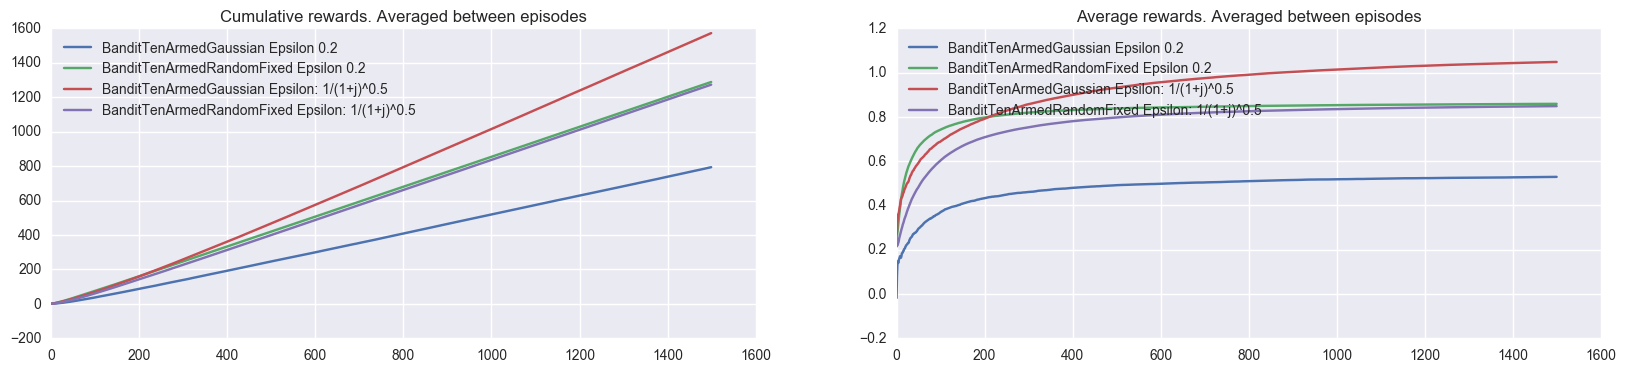

In [215]:
print(prepare_env_names(ENVS[:2],""))
get_episode_rewards(rewards_list[:2]+rewards_list_c[:2], 
                    prepare_env_names(ENVS[:2], " Epsilon 0.2") + prepare_env_names(ENVS[:2], " Epsilon: 1/(1+j)^0.5"), 
                    average_between_episodes=True)

['BanditTenArmedRandomRandom', 'BanditTenArmedUniformDistributedReward']


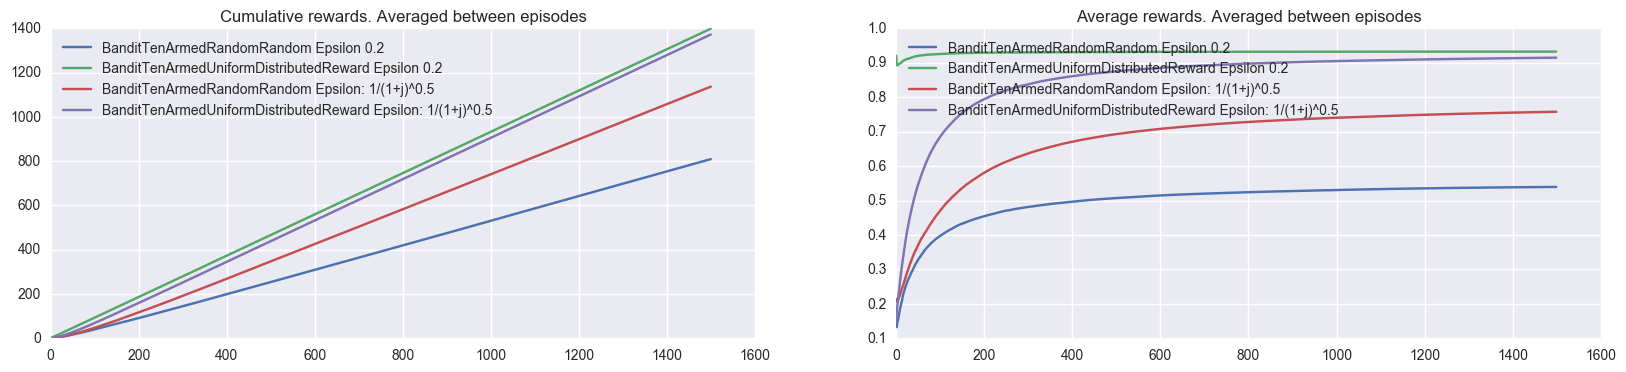

In [216]:
print(prepare_env_names(ENVS[2:4],""))
get_episode_rewards(rewards_list[2:4]+rewards_list_c[2:4], 
                    prepare_env_names(ENVS[2:4], " Epsilon 0.2") + prepare_env_names(ENVS[2:4], " Epsilon: 1/(1+j)^0.5"), 
                    average_between_episodes=True)

['BanditTwoArmedDeterministicFixed', 'BanditTwoArmedHighHighFixed']


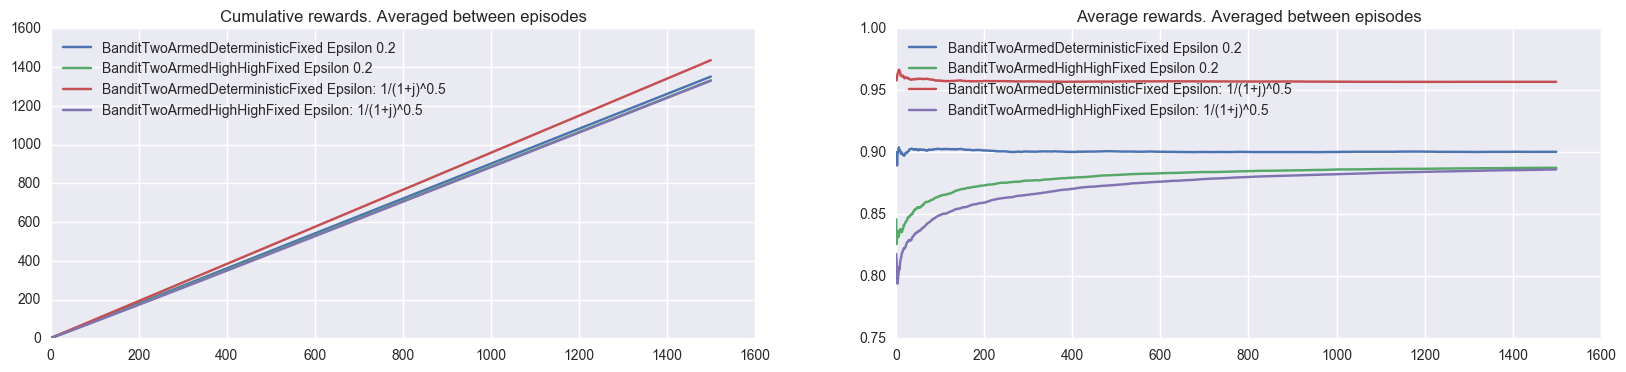

In [217]:
print(prepare_env_names(ENVS[4:6],""))
get_episode_rewards(rewards_list[4:6]+rewards_list_c[4:6], 
                    prepare_env_names(ENVS[4:6], " Epsilon 0.2") + prepare_env_names(ENVS[4:6], " Epsilon: 1/(1+j)^0.5"), 
                    average_between_episodes=True)

['BanditTwoArmedHighLowFixed', 'BanditTwoArmedLowLowFixed']


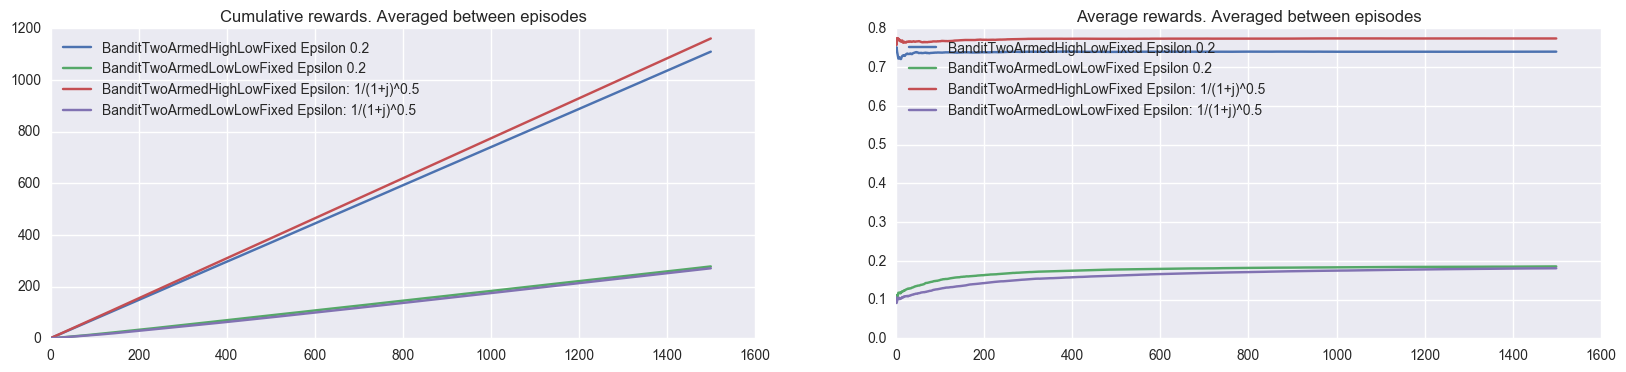

In [218]:
print(prepare_env_names(ENVS[6:8],""))
get_episode_rewards(rewards_list[6:8]+rewards_list_c[6:8], 
                    prepare_env_names(ENVS[6:8], " Epsilon 0.2") + prepare_env_names(ENVS[6:8], " Epsilon: 1/(1+j)^0.5"), 
                    average_between_episodes=True)